# Project 2 : Ames-housing Price Prediction

# Problem Statement

-  Imagine that your friends would like to buy a house in Ames. As you are a data scientist, what are the priority factors to suggest to your friends before buying a house and how could you predict the house prices from the given houses condition from your friend ?




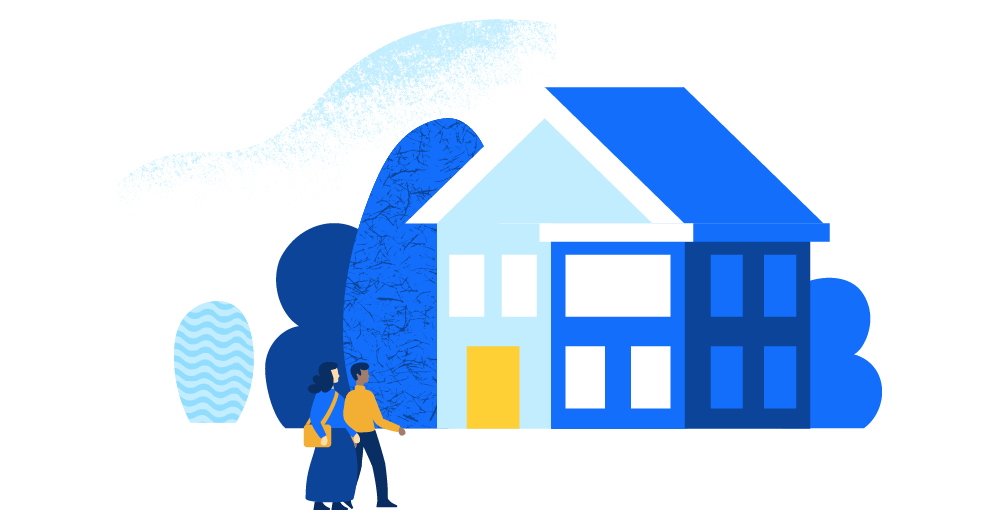

# Objectives
- To create the linear regression model for predicting the price of houses in Ames.


# Content

- [Data preparation](#Data-cleaning)
- [EDA & Visualization](#EDA-&-Visualization)
- [Modeling](#Modeling)
- [Conclusions and Recommendations](#Conclusion)

# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# screening the missing value
import missingno as msno

# Using for modeling
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,Ridge,Lasso
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.dummy import DummyRegressor # high bias model
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,OrdinalEncoder

# Import data 

In [2]:
#  training data
df = pd.read_csv('./datasets/train.csv') 

# Data cleaning

> In this section, the dataset would be divided into 2 section, including **numerical type** data and **object type** data

In [3]:
df.info()
# 81 features some contains 'NaN' and 1 target variable.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2197 entries, 0 to 2196
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2197 non-null   int64  
 1   PID              2197 non-null   int64  
 2   MS SubClass      2197 non-null   int64  
 3   MS Zoning        2197 non-null   object 
 4   Lot Frontage     1835 non-null   float64
 5   Lot Area         2197 non-null   int64  
 6   Street           2197 non-null   object 
 7   Alley            143 non-null    object 
 8   Lot Shape        2197 non-null   object 
 9   Land Contour     2197 non-null   object 
 10  Utilities        2197 non-null   object 
 11  Lot Config       2197 non-null   object 
 12  Land Slope       2197 non-null   object 
 13  Neighborhood     2197 non-null   object 
 14  Condition 1      2197 non-null   object 
 15  Condition 2      2197 non-null   object 
 16  Bldg Type        2197 non-null   object 
 17  House Style   

<AxesSubplot: >

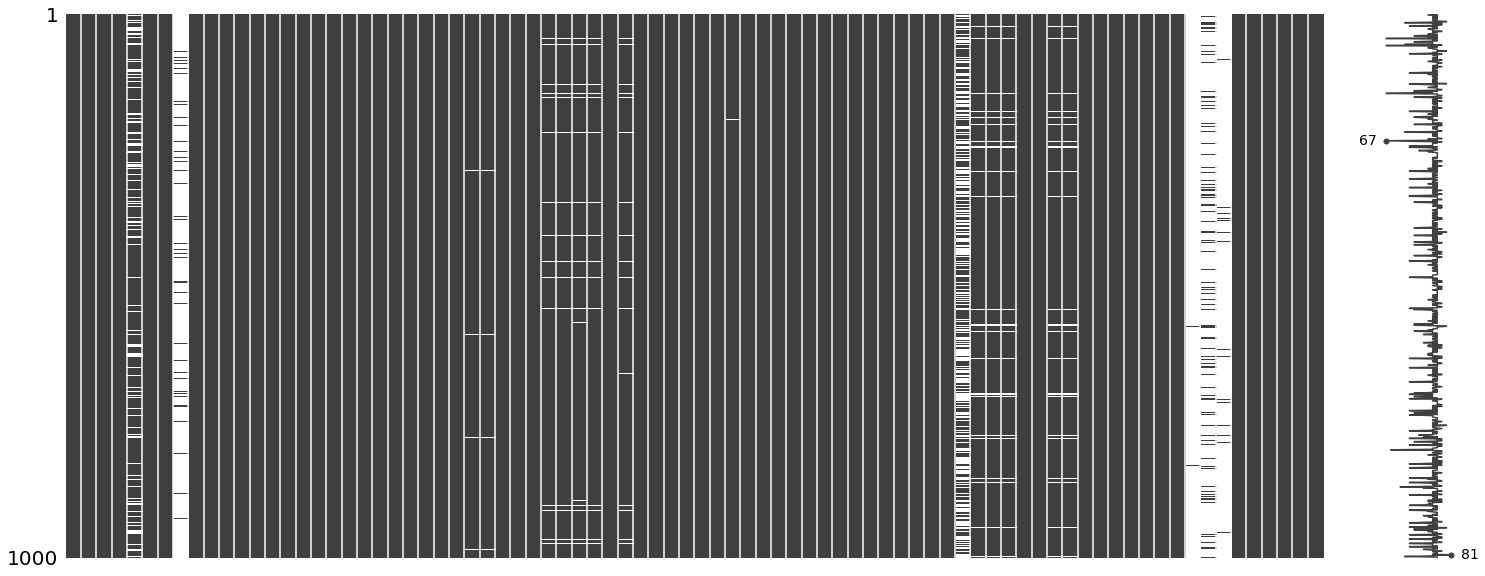

In [4]:
#  plotting missing value 
msno.matrix(df.sample(1000))

- As you can see some column has a lot of missing values, some have few, and some are no missing value. But the missing values mostly will appear on the same row. 

- So assume that the missing value is Missing completely at random (MCAR). There is no obvious relation why is it missing. Maybe that house is actually not having that data, or the observer forgot to gather that data. Then, I decided to fill numeric missing value with '0', and the missing of object type data with 'None'.

In [5]:
#Rename columns name
df.columns = df.columns.str.lower().str.replace(' ', '_')

#fill NaN for object columns , and zero for numerical columns

# select object type and fill with none
df.select_dtypes(include='object').fillna('None',inplace=True)

# # select numeric and fill with 0
df.select_dtypes(exclude='object').fillna(0,inplace=True)


#### After fill all missing values, let see the correlation of numeric type data and the saleprice.

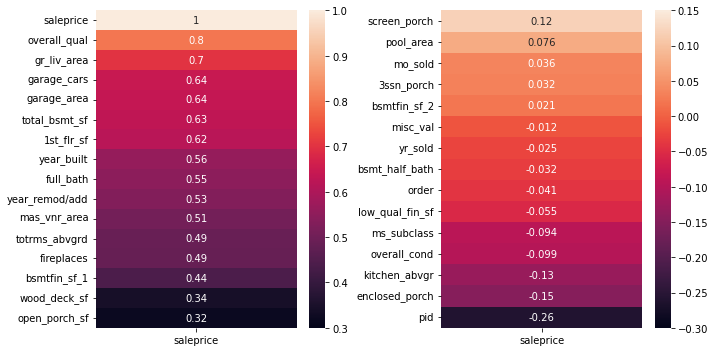

In [6]:
#plt.figure(figsize=(20,20))
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.heatmap(df.corr()[['saleprice']].sort_values(by='saleprice',ascending=False).head(16),annot=True,ax=ax[0],vmin=0.3,vmax=1);
sns.heatmap(df.corr()[['saleprice']].sort_values(by='saleprice',ascending=False).tail(15),annot=True,ax=ax[1],vmin=-0.3,vmax=0.15);
plt.tight_layout()

### These are high correlated features to saleprice, which got 15 features (corr. > 30%):
`overall_qual` , `gr_liv_area`, `garage_cars'`,`garage_area`, `total_bsmt_sf`, `1st_flr_sf`, `year_built`, `full_bath`,`year_remod/add`, `mas_vnr_area`, `totrms_abvgrd`, `fireplaces`,`bsmtfin_sf_1`, `wood_deck_sf`, `open_porch_sf`

- let see the distribution in these feature

## Cleaning outliers

In [7]:
# we will seperate into 3 group for seeking the distribution easily. 
first_5 = df[[ 'overall_qual', 'gr_liv_area', 'garage_cars',
       'garage_area', 'total_bsmt_sf','saleprice']]
second_5 =df[[ '1st_flr_sf', 'year_built', 'full_bath',
       'year_remod/add', 'mas_vnr_area','saleprice']]
third_5 = df [['totrms_abvgrd', 'fireplaces',
       'bsmtfin_sf_1', 'wood_deck_sf','open_porch_sf','saleprice']]

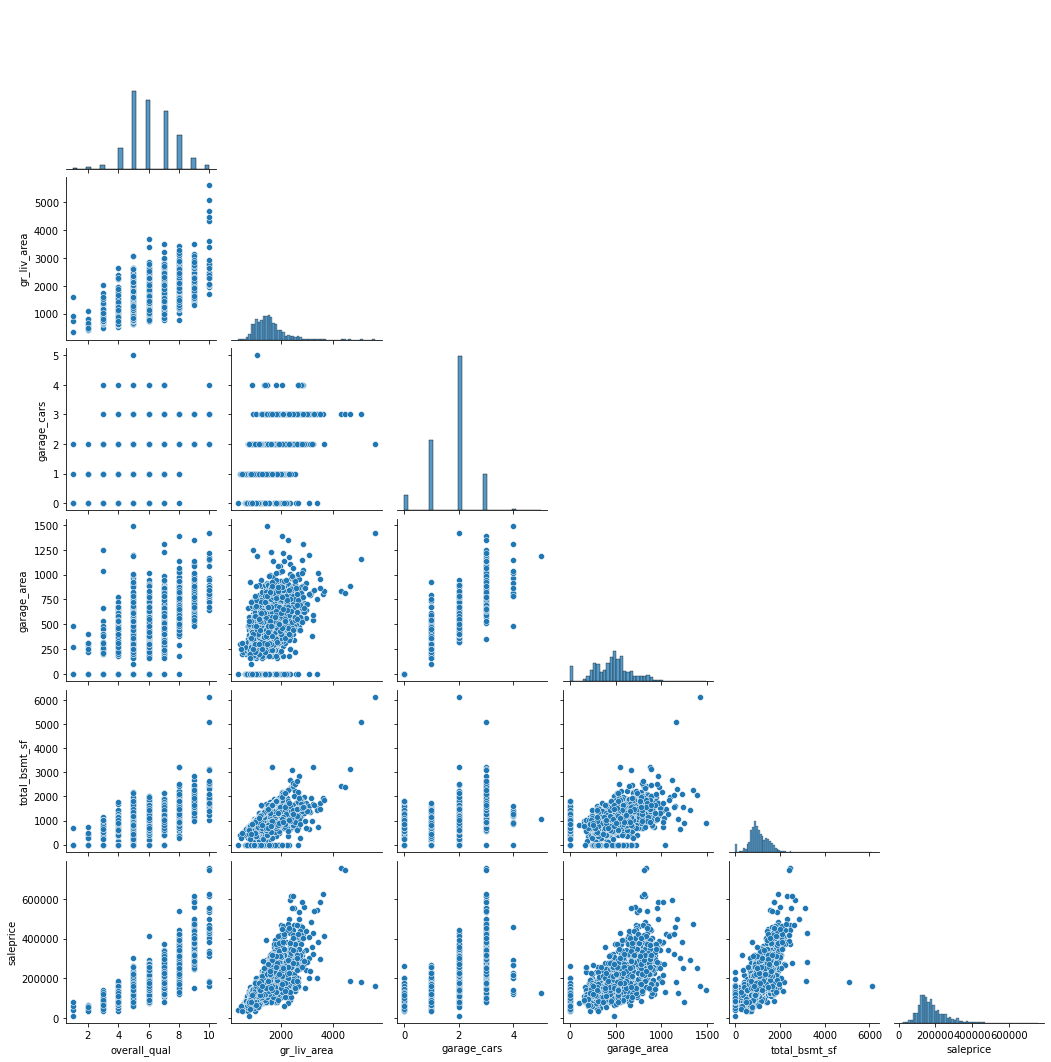

In [8]:
# using pairplot to seek the distribution
sns.pairplot(first_5,corner=True);

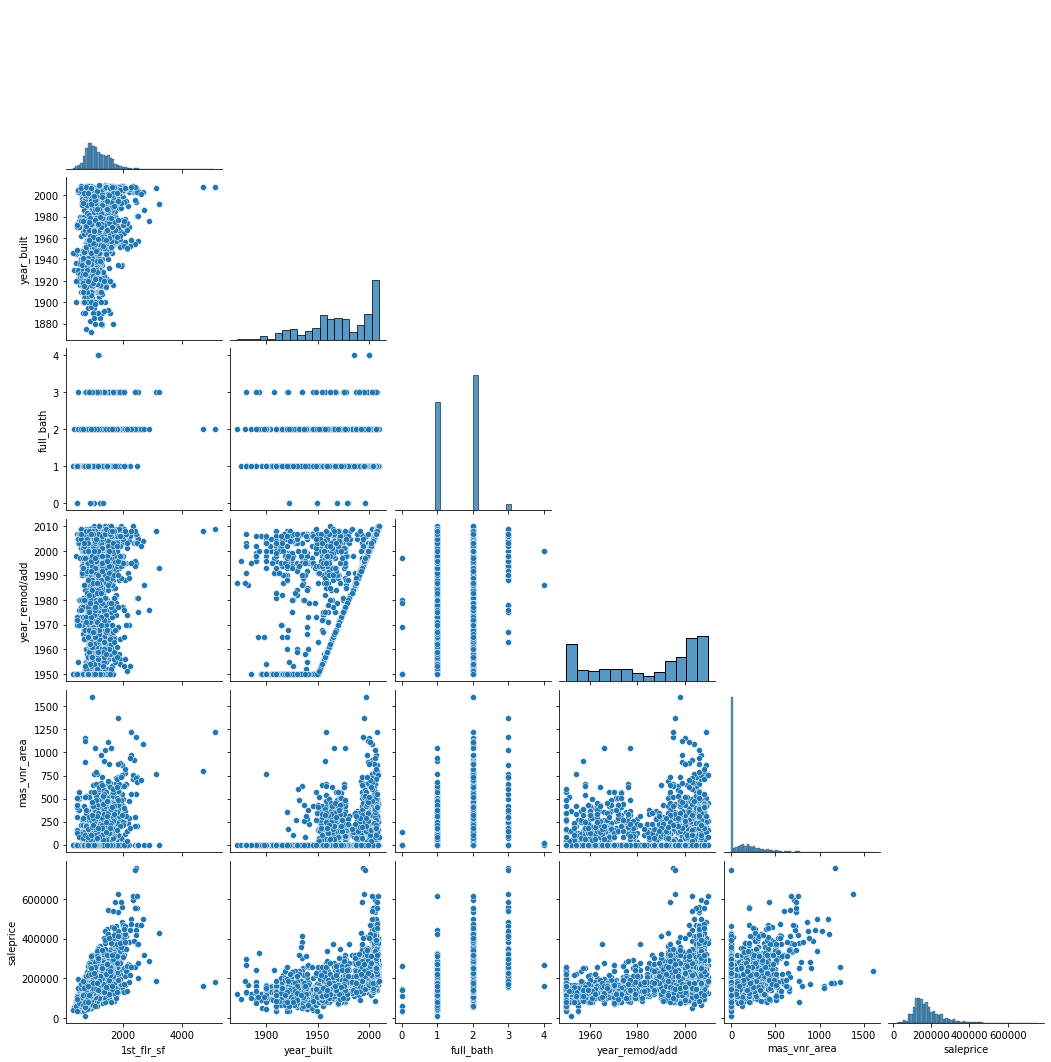

In [9]:

sns.pairplot(second_5,corner=True)

#### There is some outliers in some features, e.g. the relation of ground living area vs saleprice.  If there is an outliers existing in our data, it may indicate that our model fail to capture the important characteristics of the data.

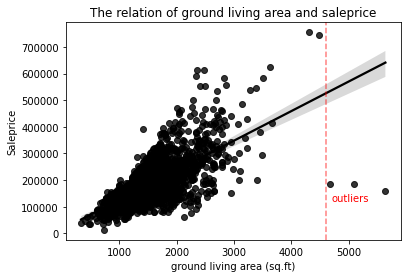

In [10]:
# Plotting the features that have outliers
sns.regplot(df['gr_liv_area'],df['saleprice'],color='black')
plt.title('The relation of ground living area and saleprice')
plt.xlabel('ground living area (sq.ft)')
plt.yticks()
plt.ylabel('Saleprice');
plt.text(x=4700,y=120000,s='outliers',color='r')
plt.axvline(4600,color='r',linestyle='--',alpha=0.5)

In [11]:
# So we clean the outliers in these columns 
df = df[ (df['total_bsmt_sf']<3000) & (df['gr_liv_area']<4000) & (df['1st_flr_sf']< 3000) \
                &(df['saleprice'] < 500000 ) & (df['mas_vnr_area']<1000) & (df['garage_area']<1200) ]

## Generate polynomial term
#### I also see some relation between features and saleprice that have curve distribution, so I decided to convert that feature into polynomial term with degree of 2.

Text(3, 350000, 'degree: 1')

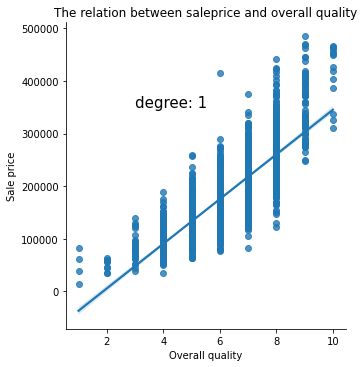

In [12]:
# If using the linear line to cover the distribution.
sns.lmplot(x='overall_qual',y='saleprice',data=df)
plt.title('The relation between saleprice and overall quality')
plt.xlabel('Overall quality')
plt.ylabel('Sale price')
plt.text(x=3,y=350000, s= 'degree: 1',fontsize=15)

Text(3, 350000, 'degree: 2')

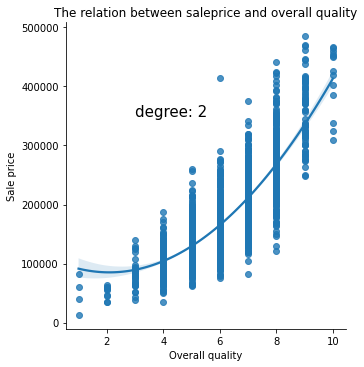

In [13]:
# If using the curve line (polynomial term - with degree of 2) to cover the distribution.
sns.lmplot(x='overall_qual',y='saleprice',data=df,order=2)
plt.title('The relation between saleprice and overall quality')
plt.xlabel('Overall quality')
plt.ylabel('Sale price')
plt.text(x=3,y=350000, s= 'degree: 2',fontsize=15)


In [14]:
# Columns that generate the polynomial term
df['over_all**2'] = df['overall_qual']**2
df['year_built**2'] = df['year_built'] **2

In [15]:
# After clean up data, and create new features(polynomial). Then group data into two group.
obj_df = df.select_dtypes(include='object') # object
num_df = df.select_dtypes(exclude='object') # numeric

## Dummied the object type data 

In [16]:
obj_df_dummy = pd.get_dummies(obj_df,drop_first=True)

In [17]:
# concat obj_df_dummy dataframe with the saleprice feature to seeking the correlation
obj_df_dummy_w_saleprice = pd.concat([obj_df_dummy,df[['saleprice']]],axis=1)

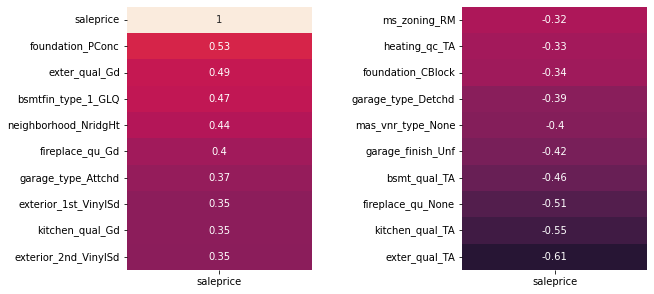

In [18]:
# Plotting the high correlated features after dummied
fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.heatmap(obj_df_dummy_w_saleprice.corr()[['saleprice']].sort_values(by='saleprice',ascending=False).head(10),annot=True,ax=ax[0],vmin=0,vmax=1,cbar=False)
sns.heatmap(obj_df_dummy_w_saleprice.corr()[['saleprice']].sort_values(by='saleprice',ascending=False).tail(10),annot=True,ax=ax[1],vmin=-0.7,vmax= 0.2,cbar=False)
plt.tight_layout(pad=4)

In [19]:
num_select = num_df

cat_select = obj_df_dummy[['foundation_PConc', 'exter_qual_Gd', 'bsmtfin_type_1_GLQ',
       'neighborhood_NridgHt', 'fireplace_qu_Gd', 'garage_type_Attchd',
       'exterior_1st_VinylSd', 'kitchen_qual_Gd', 'exterior_2nd_VinylSd',\
                        'ms_zoning_RM', 'heating_qc_TA', 'foundation_CBlock',
       'garage_type_Detchd', 'mas_vnr_type_None', 'garage_finish_Unf',
       'bsmt_qual_TA', 'fireplace_qu_None', 'kitchen_qual_TA',
       'exter_qual_TA']]
value_df = pd.concat([num_select,cat_select],axis=1)

# EDA & Visualization

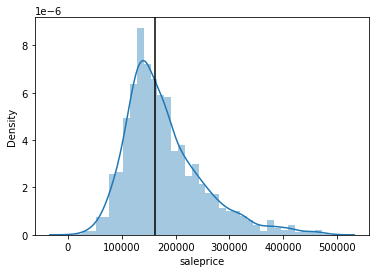

In [20]:
sns.distplot(num_df['saleprice'])
plt.axvline(num_df['saleprice'].median(),color='black')

#### The median sale price of houses at ames is around 180000 dollars.

In [21]:
df.groupby('kitchen_qual')['saleprice'].mean().sort_values(ascending=False).reset_index()

,kitchen_qual,saleprice
0,Ex,316679.187500
1,Gd,210150.891482
2,TA,139789.830154
3,Fa,107600.000000
4,Po,107500.000000


#### The more on quality of kitchen, the higher on saleprice

Text(0.5, 1.0, 'The quality of kitchen vs sale price')

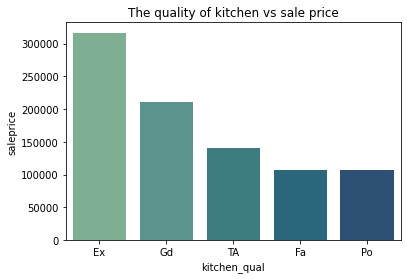

In [22]:
# The visualization of upper cell
# groupby and plot by barplot
sns.barplot(df.groupby('kitchen_qual')['saleprice'].mean().sort_values(ascending=False).reset_index()['kitchen_qual'],\
            df.groupby('kitchen_qual')['saleprice'].mean().sort_values(ascending=False).reset_index()['saleprice'],palette='crest',)
plt.title('The quality of kitchen vs sale price')

<AxesSubplot: xlabel='overall_qual', ylabel='saleprice'>

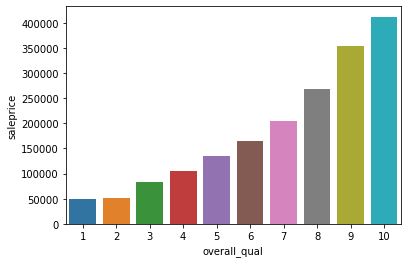

In [23]:
sns.barplot(num_df.groupby('overall_qual')['saleprice'].mean().reset_index()['overall_qual'],num_df.groupby('overall_qual')['saleprice'].mean().reset_index()['saleprice'])

#### overall quality tend to increase as the saleprice increased.

<AxesSubplot: xlabel='kitchen_qual', ylabel='Count'>

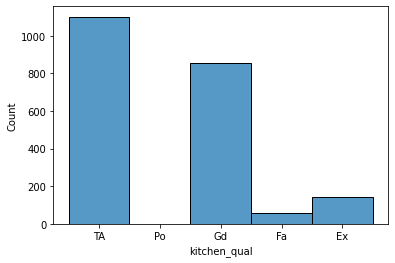

In [24]:
sns.histplot(df['kitchen_qual'].sort_values(ascending=False))

####  There is a lot of kitchen with medium quality  than high quality

In [25]:
year_sale = num_df.groupby('year_built')['saleprice'].mean().reset_index() # groupby year that house were built 
year_sale['mv_avg' ] = year_sale.saleprice.rolling( 7).mean() # average the fluctuation in the graph 

Text(0.5, 1.0, 'Timeseries of Ames-housing saleprice vs year built')

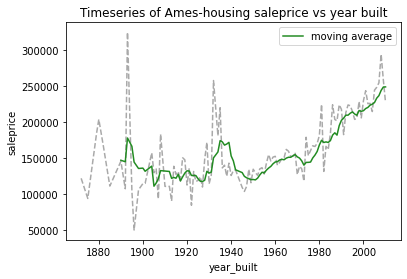

In [26]:
sns.lineplot(num_df.groupby('year_built')['saleprice'].mean().reset_index()['year_built'],\
             num_df.groupby('year_built')['saleprice'].mean().reset_index()['saleprice'],linestyle='--',color ='darkgrey')
sns.lineplot(year_sale['year_built'],\
             year_sale['mv_avg'],color='forestgreen',label='moving average')
plt.title('Timeseries of Ames-housing saleprice vs year built')

#### The sale price of houses at ames tend to increase as the year of house decrease.

In [27]:
df.groupby('overall_qual')[['gr_liv_area','saleprice']].mean() 
#groupby overall quality and see the living area size and saleprice

,gr_liv_area,saleprice
overall_qual,,
1,892.750000,48725.000000
2,639.000000,51733.600000
3,1057.562500,83085.593750
4,1146.512346,104476.135802
5,1273.751645,134823.159539
6,1456.871508,164040.769088
7,1655.131291,204674.096280
8,1861.574144,267889.034221
9,2027.121622,353324.229730


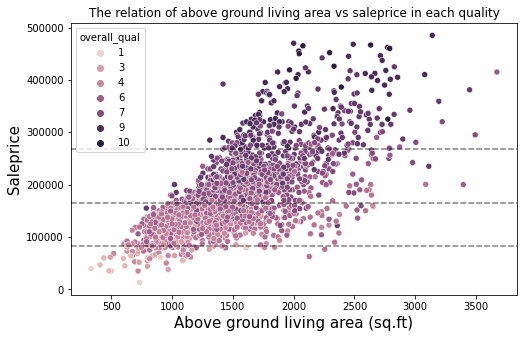

In [28]:
plt.figure(figsize=(8,5))
sns.scatterplot(df['gr_liv_area'],df['saleprice'],hue=df['overall_qual'])
plt.xlabel('Above ground living area (sq.ft)',fontsize= 15)
plt.ylabel('Saleprice',fontsize=15)
plt.title('The relation of above ground living area vs saleprice in each quality',size=12)

# plot the horizontal line that separate the value of overall quality by mean of saleprice in each overall quality  group
plt.axhline(83085.593750,linestyle='--',color= 'black',alpha = 0.5)
plt.axhline(164040.769088,linestyle='--',color= 'black',alpha = 0.5)
plt.axhline(267889.034221,linestyle='--',color= 'black',alpha = 0.5)

In [29]:
# groupby year that house were sold
year_sold = num_df.groupby('yr_sold')['saleprice'].mean().reset_index()
# average the fluctuation in the graph 
year_sold['mv_avg' ] = year_sold.saleprice.rolling(2).mean()

In [30]:
year_sold.drop(index=0,inplace=True)

Text(0.5, 1.0, 'Timeseries of Ames-housing saleprice vs year sold')

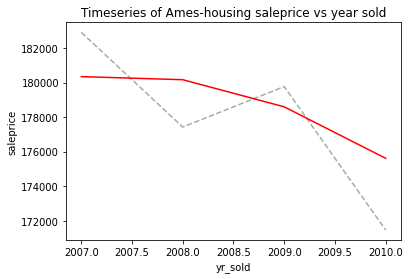

In [31]:
sns.lineplot(year_sold['yr_sold'],\
             round(year_sold['saleprice'],0),linestyle='--',color ='darkgrey')

# plot average price
sns.lineplot(year_sold['yr_sold'],\
             round(year_sold['mv_avg'],0),color='r');

plt.title('Timeseries of Ames-housing saleprice vs year sold')

#### The value of the house decreased as the age increase, because if the house sold lately the price tend to decrease.

Text(0.5, 1.0, 'The number of house categorized by quality')

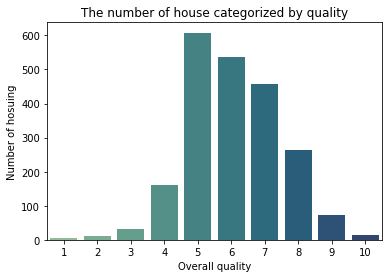

In [32]:
sns.barplot(df['overall_qual'].value_counts().index,df['overall_qual'].value_counts(),palette='crest')
plt.ylabel('Number of hosuing')
plt.xlabel('Overall quality')
plt.title('The number of house categorized by quality')

#### Most of the houses at ames, tend to have medium quality rather than high quality.

# Modeling

## Modify the testing data  

In [33]:
X_test_real = pd.read_csv('./datasets/test.csv')
X_test_real.columns = X_test_real.columns.str.lower().str.replace(' ', '_')
test_num = X_test_real.select_dtypes(exclude='object')
test_num.fillna(0,inplace=True)
test_num['over_all**2'] = test_num['overall_qual'] **3
test_num['year_built**2'] = test_num['year_built'] **2


test_cat = X_test_real.select_dtypes(include='object')
test_cat.fillna('None',inplace=True)
test_cat = pd.get_dummies(test_cat,drop_first=True)
test_cat = test_cat[['foundation_PConc', 'exter_qual_Gd', 'bsmtfin_type_1_GLQ',
       'neighborhood_NridgHt', 'fireplace_qu_Gd', 'garage_type_Attchd',
       'exterior_1st_VinylSd', 'kitchen_qual_Gd', 'exterior_2nd_VinylSd',\
                        'ms_zoning_RM', 'heating_qc_TA', 'foundation_CBlock',
       'garage_type_Detchd', 'mas_vnr_type_None', 'garage_finish_Unf',
       'bsmt_qual_TA', 'fireplace_qu_None', 'kitchen_qual_TA',
       'exter_qual_TA' ]]



test_df = pd.concat([test_num,test_cat],axis=1)

# Linear regression

In [35]:
X = value_df.drop(columns='saleprice')
y = value_df['saleprice']

In [41]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

# Intantiate
lr = LinearRegression()

# Fit
lr.fit(X_train,y_train)

# Predict
y_train_pred = lr.predict(X_test)

In [42]:
print('comparing by train/test score')
# Train score
print(f'Train R-squared score: {lr.score(X_train,y_train)}')
# Test score
print(f'Test R-squared score: {lr.score(X_test,y_test)}')
print('-------------------------------------------')
print('comparing by using cross_validation')
# Train score
print(f'Train cross_va score:{cross_val_score(lr,X_train,y_train).mean()}')
# Test score
print(f'Test cross_va score:{cross_val_score(lr,X_test,y_test).mean()}')

comparing by train/test score
Train R-squared score: 0.9216165506610354
Test R-squared score: 0.9151894996935552
-------------------------------------------
comparing by using cross_validation
Train cross_va score:0.9118210556391875
Test cross_va score:0.8900929893527131


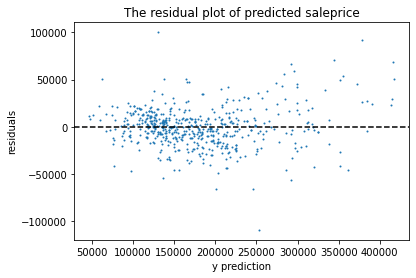

In [52]:
resid = y_test - y_train_pred
plt.scatter(y_train_pred,resid,s=1)
plt.axhline(0,color='black',linestyle='--')
plt.xlabel('y prediction')
plt.ylabel('residuals')
plt.title('The residual plot of predicted saleprice');

#### The residual seem to distributed equally - assume to be normal distribution in LINEM assumption.

In [40]:
y_pred = lr.predict(test_df) # real saleprice from real testing file

In [43]:
pd.DataFrame({'Order':X_test_real['order'], 'SalePrice':y_pred}).to_csv('./datasets/real_predict_saleprice.csv',index=False)

# LASSO

In [55]:
# Instantiate Scaler
sc = StandardScaler()

# fit train data and transform test data
Z_train = sc.fit_transform(X_train) 
Z_test_train = sc.transform(X_test)

#Instantiate Lasso
alphas = np.logspace(-3,0,100)
lasso_cv = LassoCV(alphas=alphas)
lasso_cv.fit(Z_train,y_train)

LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]))

In [56]:
print('comparing by train/test score')
# Train score
print(f'Train R-squared score: {lasso_cv.score(Z_train,y_train)}')
# Test score
print(f'Test R-squared score: {lasso_cv.score(Z_test_train,y_test)}')
print('-------------------------------------------')
print('comparing by using cross_validation')
# Train score
print(f'Train cross_va score:{cross_val_score(lasso_cv,Z_train,y_train).mean()}')
# Test score
print(f'Test cross_va score:{cross_val_score(lasso_cv,Z_test_train,y_test).mean()}')

comparing by train/test score
Train R-squared score: 0.9214816853670924
Test R-squared score: 0.9148629907404304
-------------------------------------------
comparing by using cross_validation
Train cross_va score:0.9120056380218415
Test cross_va score:0.8902884129571564


In [57]:
# The optimal alpha
lasso_cv.alpha_

0.4641588833612782

In [58]:
# Scale the real test data
Z_test_real = sc.transform(test_df)
# predict the real saleprice
y_pred = lasso_cv.predict(Z_test_real)

In [59]:
# Extract coefficient (features) that impact to saleprice
lasso_coefs = lasso_cv.coef_
lasso_coefs = pd.DataFrame(lasso_coefs, sc.get_feature_names_out(X.columns)) # take lasso coef and put the feature name

In [60]:
# sort value of in lasso coefficient dataframe
order_coef = lasso_coefs.sort_values(by= 0,ascending=False)
# Create new column to by specify color to value of the coefficient, if positive will be blue
order_coef['color_list'] = ['cornflowerblue' if x >= 0 else 'lightpink' for x in order_coef[0].values]
# take absolute of all the values, and reverse. To get only first 15 highest values.
abs(order_coef[0]).sort_values(ascending=False).index[:15][::-1]

Index(['lot_area', 'gr_liv_area', 'fireplaces', 'yr_sold', 'garage_area',
       'kitchen_qual_TA', 'kitchen_qual_Gd', 'overall_cond', 'bsmtfin_sf_1',
       '1st_flr_sf', '2nd_flr_sf', 'overall_qual', 'year_built**2',
       'over_all**2', 'year_built'],
      dtype='object')

In [61]:
order_coef[0].sort_values(ascending=False)

year_built              55886.061457
over_all**2             49831.008982
2nd_flr_sf              19001.560389
1st_flr_sf              16104.019180
bsmtfin_sf_1            12016.074192
overall_cond             8719.045075
garage_area              5939.939744
fireplaces               5080.473158
gr_liv_area              5027.186832
lot_area                 5000.005075
bsmt_unf_sf              3550.760137
fireplace_qu_None        3369.714498
fireplace_qu_Gd          3067.075849
mas_vnr_area             2968.574136
total_bsmt_sf            2954.685762
neighborhood_NridgHt     2791.592982
foundation_PConc         2684.281327
mas_vnr_type_None        2667.402832
bsmtfin_sf_2             2446.598453
year_remod/add           2001.421424
bsmtfin_type_1_GLQ       1940.306275
enclosed_porch           1794.891669
screen_porch             1663.002558
wood_deck_sf             1340.627807
exterior_2nd_VinylSd     1094.489334
pid                       933.363069
open_porch_sf             745.661812
g

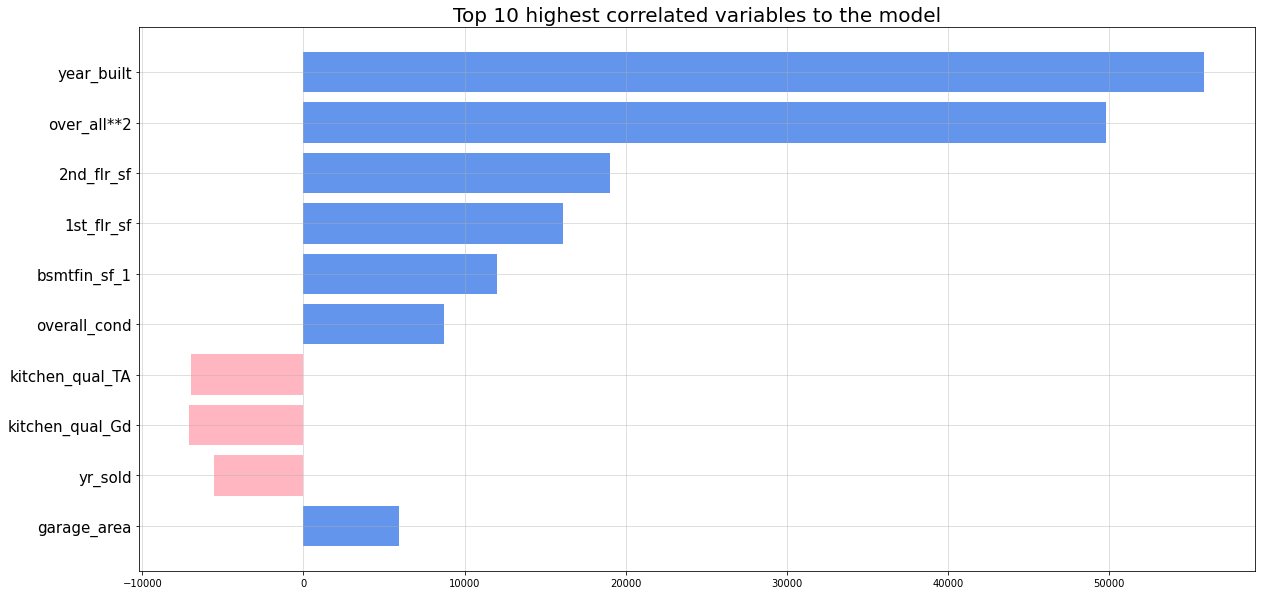

In [62]:
# Plot horizontal bar of coefficient
plt.figure(figsize=(20,10))
plt.barh(order_coef[0].loc[[
        'garage_area', 'yr_sold',
       'kitchen_qual_Gd', 'kitchen_qual_TA', 'overall_cond', 
       'bsmtfin_sf_1', '1st_flr_sf', '2nd_flr_sf', 
       'over_all**2', 'year_built']].index,order_coef[0].loc[[
        'garage_area', 'yr_sold',
       'kitchen_qual_Gd', 'kitchen_qual_TA', 'overall_cond', 
       'bsmtfin_sf_1', '1st_flr_sf', '2nd_flr_sf', 
       'over_all**2', 'year_built']],color=order_coef.loc[[
        'garage_area', 'yr_sold',
       'kitchen_qual_Gd', 'kitchen_qual_TA', 'overall_cond', 
       'bsmtfin_sf_1', '1st_flr_sf', '2nd_flr_sf',
       'over_all**2', 'year_built']]['color_list'])
plt.title('Top 10 highest correlated variables to the model',size=20)
plt.yticks(fontsize=15);
plt.grid(alpha = 0.5)

# Ridge

In [ ]:
# Try using Ridge regularization
alpha = np.logspace(0,5,100)

# Instantiate
ridge_cv =RidgeCV(alphas=alpha)
# Fit
ridge_cv.fit(Z_train,y_train)
# Predict
y_pred = ridge_cv.predict(Z_test_real)

In [ ]:
print('comparing by train/test score')
# Train score
print(f'Train R-squared score: {ridge_cv.score(Z_train,y_train)}')
# Test score
print(f'Test R-squared score: {ridge_cv.score(Z_test_train,y_test)}')
print('-------------------------------------------')
print('comparing by using cross_validation')
# Train score
print(f'Train cross_va score:{cross_val_score(ridge_cv,Z_train,y_train).mean()}')
# Test score
print(f'Test cross_va score:{cross_val_score(ridge_cv,Z_test_train,y_test).mean()}')

# Dummyregressor

In [ ]:
# Intantiate
dummy = DummyRegressor()
# Fit
dummy.fit(X_train,y_train)
# Predict from real data
y_dummy = dummy.predict(test_df)

In [ ]:
# Predict from split x_test
y_predict = dummy.predict(X_test)

In [ ]:
# rmse compare with split x_test
np.sqrt(metrics.mean_squared_error(y_test,y_predict))

In [ ]:
# score of model
round(dummy.score(X_test,y_test),2)

# Plot rmse

In [ ]:
# plotting rmse vs r^2 score
rmse = [73220,28503,26997, 25373, 23797, 23555]
r2 = [0.000, 0.757 , 0.8658, 0.886 , 0.891, 0.892]
sns.lineplot(x=np.arange(0,6),y= rmse,marker='o',color='navy',label='rmse')
plt.ylabel('Root mean square error',fontsize =12,color='navy')
plt.xlabel('number of iterations',fontsize =12)
plt.grid(alpha=0.3)
plt.xticks(np.arange(0,6))
plt.text(x= 0.2,y=71000,s='dummy-reg')
plt.text(x= 4.8,y=25000,s='Final',color='r')
plt.legend(loc=5)

plt.twinx()
sns.lineplot(x=np.arange(0,6,1),y= r2,linestyle='-.',color='slategrey')
plt.title('RMSE & R^2 through iteration modelling',size =13)
plt.ylabel('R^2 score',fontsize =12)


# Conclusion 

**About model**
- The model has 60 features, including 41 numeric features and 19 object  features.
- This model includes the use of train-test split to split the data for training and cross validation to test the performance of the model.
- This model includes clean outliers, adding polynomial terms & dummy variables, and regularization by LASSO.
- R^2 : 89.2%, RMSE: The final model can reduce RMSE by around 5000. 
- As a result, the price predicted by this model may differ from the actual value of around 23555 dollars.


 # Recommendations

- I would recommend to my friends the top 4 things that should be considered on the sale price : new (year built); quality (overall quality); comfortable (size of living area); and design (overall condition).

**About model** :
- I should add more the interaction term, e.g. overall quality and living area that have the positive relation.
- Other feature, e.g. Number of fault detection in the houses to support the overall quality feature